This notebook is licensed under the MIT License. See the [LICENSE file](https://github.com/tommasocarraro/LTNtorch/blob/main/LICENSE) in the project root for details.

## Clustering

In unsupervised learning, labels are either not available or are not used for learning. Clustering is a form of
unsupervised learning whereby, without labels, the data is characterized by constraints alone. LTN can formulate
such constraints, such as for example:
- clusters should be disjoint;
- every example should be assigned to a cluster;
- a cluster should not be empty;
- if the points are near, they should belong to the same cluster;
- if the points are far, they should belong to different clusters, etc.

For this specific task, LTN uses the following language and grounding:

**Domains:**
- $points$, denoting the data for which we have to create clusters;
- $clusters$, denoting the clusters;
- $thresholds$, denoting the thresholds for deciding whether to points are near each other or far from each other.

**Variables:**
- $x, y$ for all the points;
- $D(x) = D(y) = points$;
- $D(c) = clusters$.

**Constants:**
- $th_{close}$: the threshold under which we decide that two points are near each other;
- $th_{distant}$: the threshold over which we decide that two points are far from each other;
- $D(th_{close}) = D(th_{distant}) = thresholds$.

**Predicates:**
- $C(x, c)$: it can be interpreted as the probability that a given point $c$ belongs to a cluster $c$;
- $D_{in}(C) = points, clusters$.

**Axioms:**

- $\forall x \text{ } \exists c \text{ } C(x, c)$: each point $x$ should be assigned to some cluster $c$;
- $\forall x \text{ } \exists c \text{ } C(x, c)$: each cluster $c$ should have at least one point $x$ inside;
- $\forall(c,x,y : dist(x, y) < th_{close}) \text{ } (C(x,c) \leftrightarrow C(y,c))$: if two points $x$ and $y$ are closed
to each other, they should belong to the same cluster $c$;
- $\forall(c,x,y : dist(x, y) > th_{distant}) \text{ } \lnot(C(x,c) \land C(y,c))$: if two points $x$ and $y$ are far, they should
not belong to the same cluster $c$.

Notice the use of guarded quantifiers: all the pairs of points with Euclidean distance ($dist$) lower (resp. higher) than a value
$th_{close}$ (resp. $th_{distant}$) should belong to the same cluster (resp. should not).

$th_{close}$ and $th_{distant}$ are arbitrary threshold values that define some of the closest and most distant pairs of
points. In our example, they are set to 0.2 and 1.0, respectively.

The clustering predicate has mutually-exclusive probabilities for each cluster using a *softmax* layer. Therefore, there
is no explicit constraint about clusters being disjoint.

**Grounding:**
- $\mathcal{G}(points)=[-1, 1]^{2}$: the dataset has points in $[-1, 1]^{2}$;
- $\mathcal{G}(clusters)=\mathbb{N}^4$: we use one-hot vectors to represent the labels of 4 clusters (we assume there are
only 4 clusters in the data);
- $\mathcal{G}(x) \in [-1,1]^{m \times 2}, that is, $x$ is a sequence of $m$ points. $\mathcal{G}(x) = \mathcal{G}(y)$;
- $\mathcal{G}(c) = \langle[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1] \rangle$;
- $\mathcal{G}(th_{close}) = 0.2$;
- $\mathcal{G}(th_{distant}) = 1.0$;
- $\mathcal{G}(C \mid \theta): x,c \mapsto c^\top \cdot \operatorname{softmax}\left(\operatorname{MLP}_{\theta}(x)\right)$,
where $MLP_{\theta}$ is a Multi-Layer Perceptron with 4 output neurons corresponding to the 4 clusters.

### Dataset

Now, let's create our toy dataset.

Ground-truth data for this task is generated artificially by creating 4 centers, and generating 50 random samples
from a multivariate Gaussian distribution around each center.

After the generation, we plot our dataset. It is possible to observe that our procedure has created 4 distinct clusters, that
are denoted in the plot with 4 different colors.

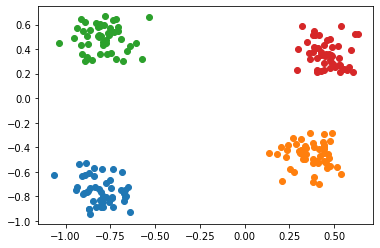

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

nr_of_clusters = 4
nr_of_points_x_cluster = 50

close_threshold = 0.2
distant_threshold = 1.0

margin = .2
mean = [np.random.uniform([-1 + margin, -1 + margin], [0 - margin, 0 - margin], 2),
        np.random.uniform([0 + margin, -1 + margin], [1 - margin, 0 - margin], 2),
        np.random.uniform([-1 + margin, 0 + margin], [0 - margin, 1 - margin], 2),
        np.random.uniform([0 + margin, 0 + margin], [1 - margin, 1 - margin], 2)]

cov = np.array([[[.01, 0], [0, .01]]] * nr_of_clusters)

cluster_data = {}
for i in range(nr_of_clusters):
    cluster_data[i] = np.random.multivariate_normal(mean=mean[i], cov=cov[i], size=nr_of_points_x_cluster)

data = np.concatenate([cluster_data[i] for i in range(nr_of_clusters)]).astype(np.float32)

for i in range(nr_of_clusters):
    plt.scatter(cluster_data[i][:, 0], cluster_data[i][:, 1])

### LTN setting

In order to define our knowledge base (axioms), we need to define predicate $C$, variables $x,y,c$, constant $th_{close}$ and
$th_{distant}$,
connectives, quantifiers, the `SatAgg` operator, and a lambda function $dist$ which computes the Euclidean distance
between two points $x$ and $y$.

For the connectives and quantifiers, we use the stable product configuration (seen in the tutorials).

For predicate $C$, we use a simple $MLP$ with three hidden layers and 4 output units.

Variable $c$ is a sequence of the cluster classes, while variables $x$ and $y$ are sequences of data points in the dataset.

`SatAgg` is defined using the `pMeanError` aggregator.

In [2]:
import ltn

# we define predicate C
class MLP(torch.nn.Module):
    """
    Here, the problem of clustering is organized as a classification task, where the classifier outputs the probability
    that the point given in input belongs to a specific cluster. The clusters are the classes of the classification
    problem.
    """
    def __init__(self, layer_sizes=(2, 16, 16, 16, 4)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, x, c):
        """
        Given a point x and a cluster c, the forward phase of this MLP returns the probability that the point x belongs
        to cluster c.

        :param x: point that has to be assigned to a cluster
        :param c: cluster for which we want to compute the probability
        :return: the probability that point x belong to cluster c
        """
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
        x = self.softmax(self.linear_layers[-1](x))
        out = torch.sum(x * c, dim=1)
        return out

C = ltn.Predicate(MLP())

# we define the variables
c = ltn.Variable("c", torch.tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]))
x = ltn.Variable("x", torch.tensor(data))
y = ltn.Variable("y", torch.tensor(data))

# we define the constants
th_close = ltn.Constant(torch.tensor(close_threshold))
th_distant = ltn.Constant(torch.tensor(distant_threshold))

# we define connectives, quantifiers, and the SatAgg operator
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndProd(), ltn.fuzzy_ops.ImpliesReichenbach()))
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=1), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=4), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

# lambda function for Euclidean distance
dist = lambda x, y: torch.unsqueeze(torch.norm(x - y, dim=1), dim=1)

### Learning

Let us define $D$ the data set of all examples. The objective function with $\mathcal{K}$
is given by $\operatorname{SatAgg}_{\phi \in \mathcal{K}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{D}}(\phi)$.

In practice, the optimizer uses the following loss function:

$\boldsymbol{L}=\left(1-\underset{\phi \in \mathcal{K}}{\operatorname{SatAgg}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{B}}(\phi)\right)$

where $B$ is a mini batch sampled from $D$.

In the following, we learn our LTN in the clustering task using the satisfaction of the knowledge base as
an objective. In other words, we want to learn the parameters $\theta$ of predicate $C$ in such a way the
axioms in the knowledge base are maximally satisfied.

We train our model for 1000 epochs and use the `Adam` optimizer.
In particular, for $\forall$ we use `pMeanError` with $p=4$, while for $\exists$ we use `pMean` with $p=1$ in the first
100 epochs and $p=6$ thereafter.

In [3]:
optimizer = torch.optim.Adam(C.parameters(), lr=0.001)

for epoch in range(1000):
    if epoch <= 100:
        p_exists = 1
    else:
        p_exists = 6
    optimizer.zero_grad()
    sat_agg = SatAgg(
        Forall(x, Exists(c, C(x, c), p=p_exists)),
        Forall(c, Exists(x, C(x, c), p=p_exists)),
        Forall([c, x, y], Equiv(C(x, c), C(y, c)),
               cond_vars=[x, y],
               cond_fn=lambda x, y: torch.lt(dist(x.value, y.value), th_close.value)),
        Forall([c, x, y], Not(And(C(x, c), C(y, c))),
               cond_vars=[x, y],
               cond_fn=lambda x, y: torch.gt(dist(x.value, y.value), th_distant.value))
    )
    loss = 1. - sat_agg
    loss.backward()
    optimizer.step()

    # we print metrics every 100 epochs of training
    if epoch % 100 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f " % (epoch, loss, sat_agg))

 epoch 0 | loss 0.5594 | Train Sat 0.441 
 epoch 100 | loss 0.5578 | Train Sat 0.442 
 epoch 200 | loss 0.3447 | Train Sat 0.655 
 epoch 300 | loss 0.1500 | Train Sat 0.850 
 epoch 400 | loss 0.1475 | Train Sat 0.853 
 epoch 500 | loss 0.1468 | Train Sat 0.853 
 epoch 600 | loss 0.1465 | Train Sat 0.853 
 epoch 700 | loss 0.1463 | Train Sat 0.854 
 epoch 800 | loss 0.1463 | Train Sat 0.854 
 epoch 900 | loss 0.1462 | Train Sat 0.854 


Notice that in this example we do not have a data loader like in previous examples. In fact, variables $x$ and $y$ are
grounded with the entire dataset just one time before the beginning of the training.

Notice also that `SatAgg` takes as input the four axioms we have specified above and returns a truth value which can be
interpreted as the satisfaction level of the entire knowledge base.

Note that after 500 epochs of training the satisfaction level of the knowledge base is around 0.8. This shows
the power of LTN in learning the clustering task only using the satisfaction of a knowledge base as an objective.

In the following, we plot the truth values of predicate $C$ for all the possible pairs $(x_i, c_j)$, where $x_i$ is a data
point of the dataset and $c_j$ is the label of some cluster. It is possible to
observe that LTN has learned how to perform the clustering perfectly.

However, it is important to note that this is a really simplified example which is far from a real clustering problem where
clusters could potentially be overlapping. Also, note that in this example we knew there were 4 clusters since we have crated
the dataset by our own. In real clustering problems, the number of cluster is a hyper-parameter of the clustering algorithm.


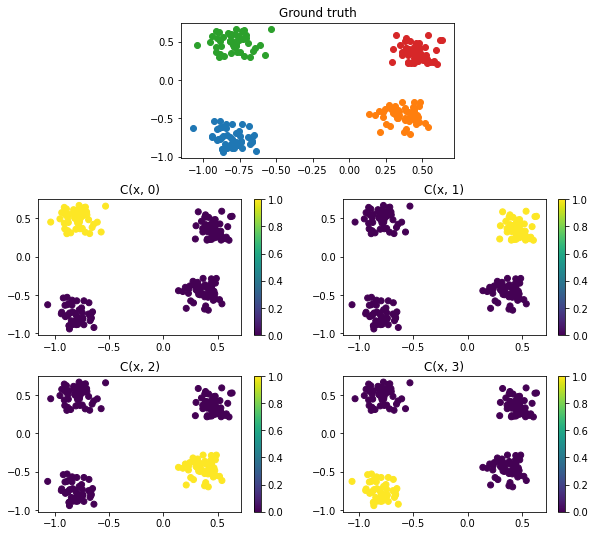

In [4]:
# graphical visualization of the results

x0 = data[:, 0]
x1 = data[:, 1]

cluster_labels = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

prC = [C.model(torch.tensor(data), torch.tensor([i] * len(data))).detach().numpy()
       for i in cluster_labels]
n = 2
m = (nr_of_clusters + 1) // n + 1

fig = plt.figure(figsize=(10, m * 3))

plt.subplots_adjust(wspace=0.2, hspace=0.3)
ax = plt.subplot2grid((m, 8), (0, 2), colspan=4)
ax.set_title("Ground truth")
for i in range(nr_of_clusters):
    ax.scatter(cluster_data[i][:, 0], cluster_data[i][:, 1])

for i in range(nr_of_clusters):
    fig.add_subplot(m, n, i + 3)
    plt.title("C(x, "+ str(i) +")")
    plt.scatter(x0, x1, c=prC[i], vmin=0, vmax=1)
    plt.colorbar()

plt.show()